# Using Autoregressive models to forecast sine signal

In [2]:
# Importing required libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [3]:
data = np.loadtxt(f'sine_data/sine_123_1000_1.csv', delimiter = ",",skiprows = 1)
# data = data[0]
data = pd.DataFrame(data)
data = data[1]
print(type(data))

<class 'pandas.core.series.Series'>


In [22]:
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

# auto_arima function was run in the AR_script.py file
  

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# Split data into train / test sets
split = 0.9
split_value = int(len(data) -len(data)*split)
train = data.iloc[:len(data)-split_value] 
test = data.iloc[len(data)-split_value:]

print(len(train))

model = ARIMA(train, order=(3,0,1), seasonal_order=(0,0,0,0))
res = model.fit()
res.summary()

900


/home/fredrik/anaconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      1   No. Observations:                  900
Model:                 ARIMA(3, 0, 1)   Log Likelihood                8101.629
Date:                Thu, 09 May 2024   AIC                         -16191.258
Time:                        13:39:24   BIC                         -16162.444
Sample:                             0   HQIC                        -16180.251
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.363e-05    1.4e-07   -168.922      0.000   -2.39e-05   -2.34e-05
ar.L1          1.4993   1.01e-05   1.48e+05      0.000       1.499       1.499
ar.L2         -0.1823    5.1e-06  -3.58e+04      0.000      -0.182      -0.182
ar.L3         -0.4249   3.33e-07  -1.28e+06      0.000      -0.425      -0.425
ma.L1       6.009e-05   4.35e-11   1.38e+06      0.000    6.01e-05    6.01e-05
sigma2      8.191e-10    9.4e-11      8.717      0.000    6.35e-10       1e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):          30088195.32
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            29.92
Prob(H) (two-sided):                  0.00   Kurtosis:                       896.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+27. Standard errors may be unstable.
"""

/home/fredrik/anaconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

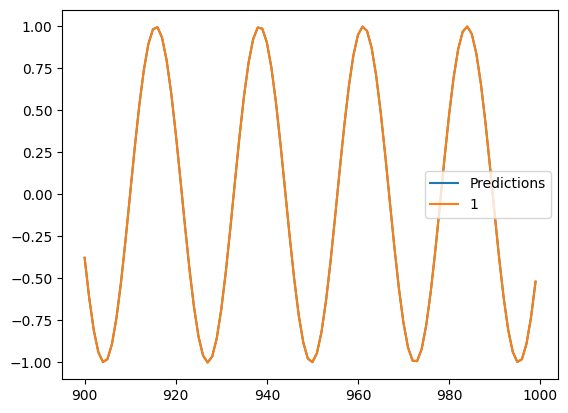

In [33]:
start = len(train) 
end = len(train) + len(test) - 1

# Predictions for one-year against the test set 
predictions = res.predict(start, end, 
							typ = 'levels').rename("Predictions") 

# plot predictions and actual values 
predictions.plot(legend = True) 
test.plot(legend = True) 


In [34]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
RMSE = rmse(test, predictions) 
  
# Calculate mean squared error 
MSE = mean_squared_error(test, predictions) 

print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

RMSE: 5.915546286736418e-05
MSE: 3.4993687870521023e-09


### Make predictions

/home/fredrik/anaconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/fredrik/anaconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fredrik/anaconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fredrik/anaconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a T

<Axes: >

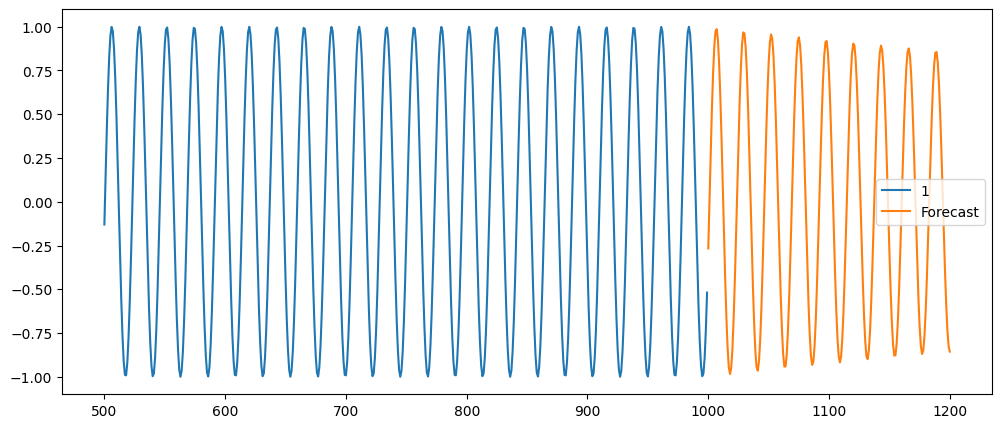

In [36]:
model = ARIMA(data, order=(3,0,1), seasonal_order=(0,0,0,0))

result = model.fit()

forecast = result.predict(start = len(data),
                          end = len(data) + 200,
                          typ = 'levels').rename('Forecast')

data.iloc[500:].plot(figsize=(12,5), legend=True)
forecast.plot(legend=True)

The problem with using ARIMA, is that it can only handle univariate data. To use ARIMA for our multivariate data, we have to apply it separately to each feature dimension. Since we want to generate all dimensions at once (to maintain interdimensional correlations), we need to try another method. One known alternative is VAR (Vector auto regressive) models


# VAR model
To tackle the problem of lacking multivariate computablility, we instead use a Vectorized Autoregressive (VAR) model which can handle multivariate time series.

The following code is taken from David Andrés at [Machine learning pills](https://mlpills.dev/time-series/step-by-step-guide-to-multivariate-time-series-forecasting-with-var-models/)

In [24]:
import statsmodels.api as sm

dim = 6
# data = np.loadtxt(f'sine_data/sine_123_1000_9.csv', delimiter = ",",skiprows = 1) #Simple sine
data = np.loadtxt(f'complex_sine_data/extra_comp_sine_123_1000_{6}.csv', delimiter = ",",skiprows = 1) #Complex sine
data = pd.DataFrame(data)
# df.head()
# Split data into train / test sets
split = 0.9
split_value = int(len(data) -len(data)*split)
train = data.iloc[:len(data)-split_value] 
test = data.iloc[len(data)-split_value:]
print(len(train))

900


In [25]:
# Chaeck for stationarity
from statsmodels.tsa.stattools import adfuller

for variable in train.columns:

    # Perform the ADF test
    result = adfuller(train[variable])

    # Extract and print the p-value from the test result
    p_value = result[1]
    print("p-value:", p_value)

    # Interpret the result
    if p_value <= 0.05:
        print(f"The variable {variable} is stationary.\n")
    else:
        print(f"The variable {variable} is not stationary.\n")

p-value: 0.0
The variable 0 is stationary.

p-value: 0.0
The variable 1 is stationary.

p-value: 0.0
The variable 2 is stationary.

p-value: 0.0
The variable 3 is stationary.

p-value: 0.0
The variable 4 is stationary.

p-value: 0.0
The variable 5 is stationary.



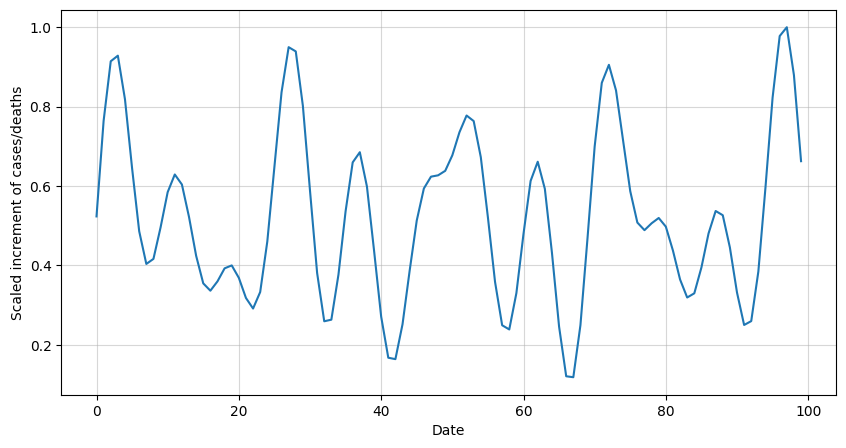

In [27]:
# Even though the data is already between -1 and 1, 
#we add this so it can be applied to more irregular data sets too
# Import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# Transform data
scaled_values = scaler.fit_transform(train)

# Convert to dataframe
df_scaled = pd.DataFrame(scaled_values, 
                         columns=train.columns, 
                         index=train.index)

# Visualize data
df_scaled[0].iloc[:100].plot(figsize=(10,5))
plt.grid(alpha=0.5, which='both')
plt.xlabel('Date')
plt.ylabel('Scaled increment of cases/deaths')
plt.show()

In [28]:
# Do the same for the test set
# Define function for data transformation
def df_test_transformation(df, test_start_date, scaler):
    
    # Apply differencing to make data stationary
    df_diff = df.diff().dropna()
    
    # Scale data using the previously defined scaler
    df_scaled = pd.DataFrame(scaler.fit_transform(df_diff), 
                         columns=df_diff.columns, 
                         index=df_diff.index)
    
    # Select only the data that belongs to the testing set
    df_test_processed = df_scaled[df_scaled.index > test_start_date]
    
    return df_test_processed

# Define function for inverting data transformation
def df_inv_transformation(df_processed, df, scaler):
    
    # Invert StandardScaler transformation
    df_diff = pd.DataFrame(scaler.inverse_transform(df_processed), 
                                columns=df_processed.columns, 
                                index=df_processed.index)

    # Invert differenting
    df_original = df_diff.cumsum() + df[df.index < df_diff.index[0]].iloc[-1]
    
    return df_original

# Apply function to our data
df_test_processed = df_test_transformation(data, df_scaled.index[-1], scaler)

In [20]:
# Start VAR model
# Import library
from statsmodels.tsa.vector_ar.var_model import VAR

# Insantiate VAR model
model = VAR(df_scaled)

# Get optimal lag order based on the four criteria
optimal_lags = model.select_order()

print(f"The optimal lag order selected: {optimal_lags.selected_orders}")

LinAlgError: 2-th leading minor of the array is not positive definite

In [29]:
# Fit the model
# Fit the model after selecting the lag order
lag_order = 9
results = model.fit(lag_order)

# Estimate the model (VAR) and show summary
var_model = results.model
results.summary()

/home/fredrik/anaconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/tsa/vector_ar/var_model.py:1558: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, May, 2024
Time:                     11:57:33
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -397.407
Nobs:                     891.000    HQIC:                  -398.504
Log likelihood:           170580.    FPE:               4.34419e-174
AIC:                     -399.182    Det(Omega_mle):    3.03269e-174
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.008150         0.000000     -1509664.208           0.000
L1.0          0.515850              NAN              NAN             NAN
L1.1          0.187039         0.000000     21559125.035           0.000
L1.2         -0.176237 

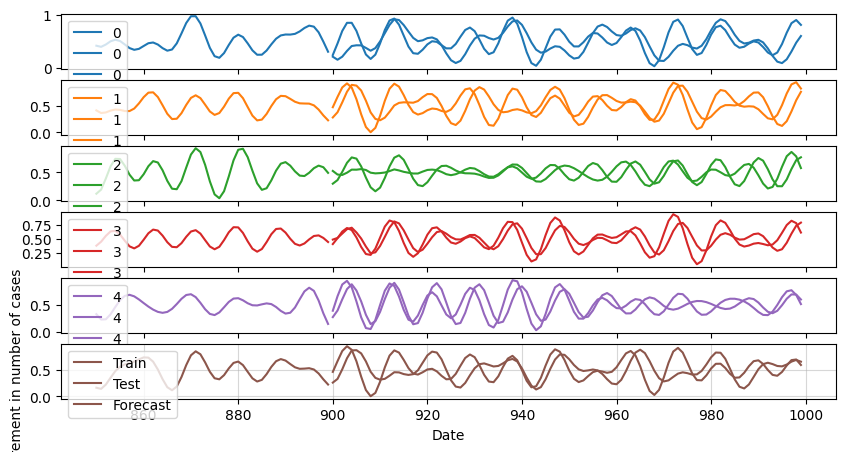

In [30]:
# Forecasting
# Forecast next two weeks
horizon = 100
forecast = results.forecast(df_scaled.values[-lag_order:], steps=horizon)

# Convert to dataframe
df_forecast = pd.DataFrame(forecast, 
                           columns=df_scaled.columns, 
                           index=test.iloc[:horizon].index)

# Plot forecasted increment of cases
ax = df_scaled[-50:].plot(figsize=(10,5), subplots=True)
df_test_processed[:horizon].plot(ax=ax, subplots=True)
df_forecast.plot(ax=ax, subplots=True)
plt.grid(alpha=0.5, which='both')
plt.xlabel('Date')
plt.ylabel('Increment in number of cases')
plt.legend(['Train', 'Test', 'Forecast'])
plt.show()

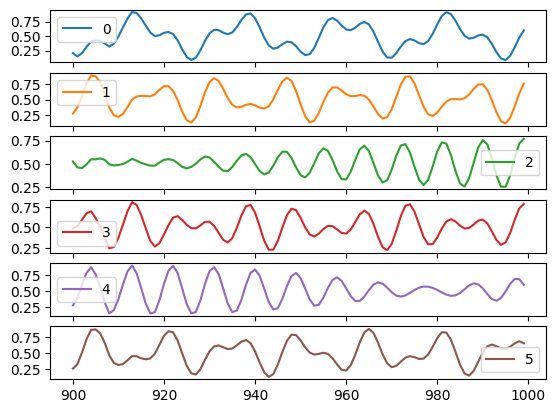

In [31]:
import datetime
import os
# Look at the isolated forecast
df_forecast.plot(subplots=True)

# Save generated data to csv
x = datetime.datetime.now()

timestamp = x.strftime("%d%m%y_%Hh%M")
# generated_df = list_to_df(generated_data)

############### BE AWARE WHICH FILE YOU SAVE TO
filepath = os.path.join('synthetic_complex_sines', 'var', f'extra_comp_syn_sine_{dim}_{horizon}_{timestamp}.csv')
df_forecast.to_csv(filepath, index=False)
